![datiaperti logo](images/datiaperti_small.png)

# The Copernicus Atmosphere Monitoring Service
The Copernicus Atmosphere Monitoring Service ([CAMS](https://atmosphere.copernicus.eu/)) provides information related to air quality, atmospheric composition, greenhouse gases, solar irradiance. CAMS is operated by the European Centre for Medium-Range Weather Forecasts ([ECMWF](https://www.ecmwf.int/)) on behalf of the European Commission.

## The CAMS solar radiation time-series
The CAMS provides the [solar radiation time-series](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-solar-radiation-timeseries) dataset with historical data, from 2004 to present, of the downwelling [solar irradiance](https://en.wikipedia.org/wiki/Solar_irradiance) at ground level on horizontal surfaces, integrated over the whole spectrum. The solar irradiance is used to plan the deployment of thermal or photovoltaic solar power plant. The solar irradiance represents the energy per unit time and unit area received from the sun in the form of electromagnetic radiation. It is measured in watts per square metre ($W/m^2$). The CAMS service returns the solar radiation, that is the solar irradiance integrated over a period of time, whose unit is watts hour per square metre ($Wh/m^2$). The solar irradiance data from CAMS is computed from two radiative transfer models. One that doesn't take into account the cloud coverage, so called clear-sky irradiance, and another one that does take into account the cloud cover, called all-sky irradiance. The cloud cover used to compute the all-sky irradiance is available from the [Meteosat 2nd generation](https://www.eumetsat.int/meteosat-second-generation) (MSG) geostationary satellites.

The purpose of this notebook is to

1. Test the CAMS solar radiation web service API
2. Plot the time series data for a given time interval
3. As an exercise, we find out the day of the strongest irradiance attenuation in the given time interval 

## CAMS radiation transfer models
The CAMS has developed two radiation transfer models to compute the solar radiation at the ground level. Since the energy emitted by the sun is known, it is possible to build a baseline model of the solar irradiance that should arrive at the ground level at any location, longitude and latitude, and at any given time in a year if the atmosphere was absent.  
![CAMS radiation transfer models](images/cams_radiation_transfer_model.png)

### Clear-sky solar irradiance
The atmosphere contains particles and trace gases, such as ozone, aerosols and water vapour, that absorb and scatter the radiation resulting in a decreased irradiance compared to that observed at the ground level. A more sophisticated computational model than the baseline discussed above, can take into account these constituents of the atmosphere and other parameters such as the temperature profile and pressure, to compute the solar irradiance under clear-sky conditions, that is a sky without cloud cover. This is the type of model used by CAMS to compute the clear-sky solar irradiance. Clearly this model needs information about the aerosols and other constituents of the atmoshere as input.

### All-sky solar irradiance
As everyone knows by experience, clouds have a strong impact on the solar irradiance that arrives at the ground level. Since the Meteosat satellites provide data about the cloud coverage in a continuous way, the solar irradiance model can remove from the clear-sky solar irradiance the quantity that is absorbed and scattered by the clouds when and where they are present. This quantity is computed from the physical characteristics of the clouds that can be inferred from their reflectance. Since the MSG satellites cover only Europe, Africa, the Atlantic Ocean and the Middle East, the all-sky solar irradiance values are not available in other regions. More information about the computational models is available in the referred papers at the end of the notebook.

## The CAMS solar radiation web service
The CAMS provide the solar irradiance data as open data, available to all for free, through a web service. A user can select 

- the location of interest 
- the time period
- the integration time of each record, from 1 minute to 1 hour
- the format of the data (CSV, NetCDF)

We import all the Python packages that will be used to retrieve the data. We will import additional packages later on for plotting the time series.

In [1]:
import pandas as pd
import cdsapi
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("python version: %s"%python_version())
print("pandas version: %s"%pd.__version__)

python version: 3.11.5
pandas version: 2.1.1


### Retrieving the solar irradiance data
We use the CAMS web service to retrieve the solar irradiance data computed for Rome, whose latitude and longitude are (41.89, 12.49), in the time period between June 17th 2022 and July 17th 2022. As soon as the request is completed a CSV file will be downloaded in the current folder. In this notebook we use the web service through its API. In order to use the API, you have to be registered into the CADS and

1. login 
2. copy your ADS API key in the .condarc file in your home folder 
3. install the cdsapi Python package

You can also pass your API key and the web service url to the client API instead of copying them into your .condarc file. For more information follow the [how-to instructions](https://ads.atmosphere.copernicus.eu/api-how-to). Pay attention to not confuse the ADS API key with the CDS API key that is used to access other data sets.

In [2]:
path = 'data'
file_name = 'solar_radiation.csv'
start_day = '2022-06-17'
end_day = '2022-07-17'
latitude = 41.89
longitude = 12.49

In [43]:
URL = "https://ads.atmosphere.copernicus.eu/api/v2"
KEY = "xxxxxxxxxxxxxxxxxxxxxxxxxxxx"
c = cdsapi.Client(url=URL, key=KEY)  # uncomment using your API key if you do not use the .condarc file

#c = cdsapi.Client()  # comment this line if you are sending your API key in the request

c.retrieve(
    'cams-solar-radiation-timeseries',
    {
        'sky_type': 'observed_cloud',
        'location': {
            'latitude': latitude,
            'longitude': longitude,
        },
        'altitude': '-999.',
        'date': start_day + '/' + end_day,
        'time_step': '1hour',
        'time_reference': 'universal_time',
        'format': 'csv',
    },
    'data/solar_radiation.csv')

2022-07-19 12:34:19,954 INFO Welcome to the CDS
2022-07-19 12:34:19,956 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-solar-radiation-timeseries
2022-07-19 12:34:20,082 INFO Request is queued
2022-07-19 12:34:21,211 INFO Request is running
2022-07-19 12:34:28,702 INFO Request is completed
2022-07-19 12:34:28,705 INFO Downloading https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data3/adaptor.cams_solar_rad.retrieve-1658226860.4718943-7090-6-4c3159c3-7388-4cbb-9db0-b9c9fa262996.csv to data/solar_radiation.csv (92.8K)
2022-07-19 12:34:29,985 INFO Download rate 72.9K/s 


Result(content_length=95065,content_type=text/plain,location=https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data3/adaptor.cams_solar_rad.retrieve-1658226860.4718943-7090-6-4c3159c3-7388-4cbb-9db0-b9c9fa262996.csv)

We open the CSV file and print the first rows to have a look at the data.

In [3]:
solar_dataset = pd.read_csv("data/solar_radiation.csv", sep=';', skiprows=42)
solar_dataset[0:5]

,# Observation period,TOA,Clear sky GHI,Clear sky BHI,Clear sky DHI,Clear sky BNI,GHI,BHI,DHI,BNI,Reliability
0,2022-06-17T00:00:00.0/2022-06-17T01:00:00.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0
1,2022-06-17T01:00:00.0/2022-06-17T02:00:00.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0
2,2022-06-17T02:00:00.0/2022-06-17T03:00:00.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0
3,2022-06-17T03:00:00.0/2022-06-17T04:00:00.0,12.6188,3.4203,0.4848,2.9355,11.1109,2.1472,0.0000,2.1472,0.0000,1.0
4,2022-06-17T04:00:00.0/2022-06-17T05:00:00.0,189.8105,88.3270,42.2906,46.0363,260.7206,79.1792,34.0331,45.1461,193.5804,1.0


The data set contains the Global Horizontal Irradiance (GHI), the Diffuse Horizontal Irradiance (DHI) and the Beam Normal Irradiance (BNI) for both the clear-sky and all-sky models. In this notebook we use only the GHI and clear-sky GHI. The GHI is the sum of the direct irradiance and the diffuse irradiance on a horizontal surface. 

## Finding out the day with the strongest irradiance attenuation
We want to plot the clear-sky GHI and the all-sky GHI and then we will find out the day in which the attenuation of the solar irradiance was the strongest in the selected period.

### Pandas Time Series
We use the Pandas Series object to handle the time series data. The Pandas Series can use timestamps as an index instead of integers as in an array. We first build the index object from the time stamps available in the data and then we'll use the index and the irradiance values to build a time series object.

In [4]:
hourly_observations = solar_dataset['# Observation period']
dates_left = [observation.split('/')[0] for observation in hourly_observations]
dates_index = pd.to_datetime(dates_left)
dates_index[0:5]

DatetimeIndex(['2022-06-17 00:00:00', '2022-06-17 01:00:00',
               '2022-06-17 02:00:00', '2022-06-17 03:00:00',
               '2022-06-17 04:00:00'],
              dtype='datetime64[ns]', freq=None)

Now we create the clear-sky irradiance time series.

In [5]:
cs_ghi = solar_dataset['Clear sky GHI']
cs_ghi_ts = pd.Series(cs_ghi.values, index=dates_index)

In the same way we create the all-sky irradiance time series

In [6]:
ghi = solar_dataset['GHI']
ghi_ts = pd.Series(ghi.values, index=dates_index)

### Plotting the solar irradiance
We compute the start and end date of the selected period that will be used to print the tick labels of the plotted data.

In [7]:
start_day = dates_index[0].strftime('%Y-%m-%d')
end_day = dates_index[dates_index.size - 1].strftime('%Y-%m-%d')
days = pd.date_range(start_day, end_day, freq='D')
print("Start day: {0:4s}\nEnd day: {1:4s}".format(start_day, end_day))

Start day: 2022-06-17
End day: 2022-07-17


In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import matplotlib.dates as mdates
print("matplotlib version: %s"%matplotlib.__version__)
print("seaborn version: %s"%seaborn.__version__)

matplotlib version: 3.8.0
seaborn version: 0.13.0


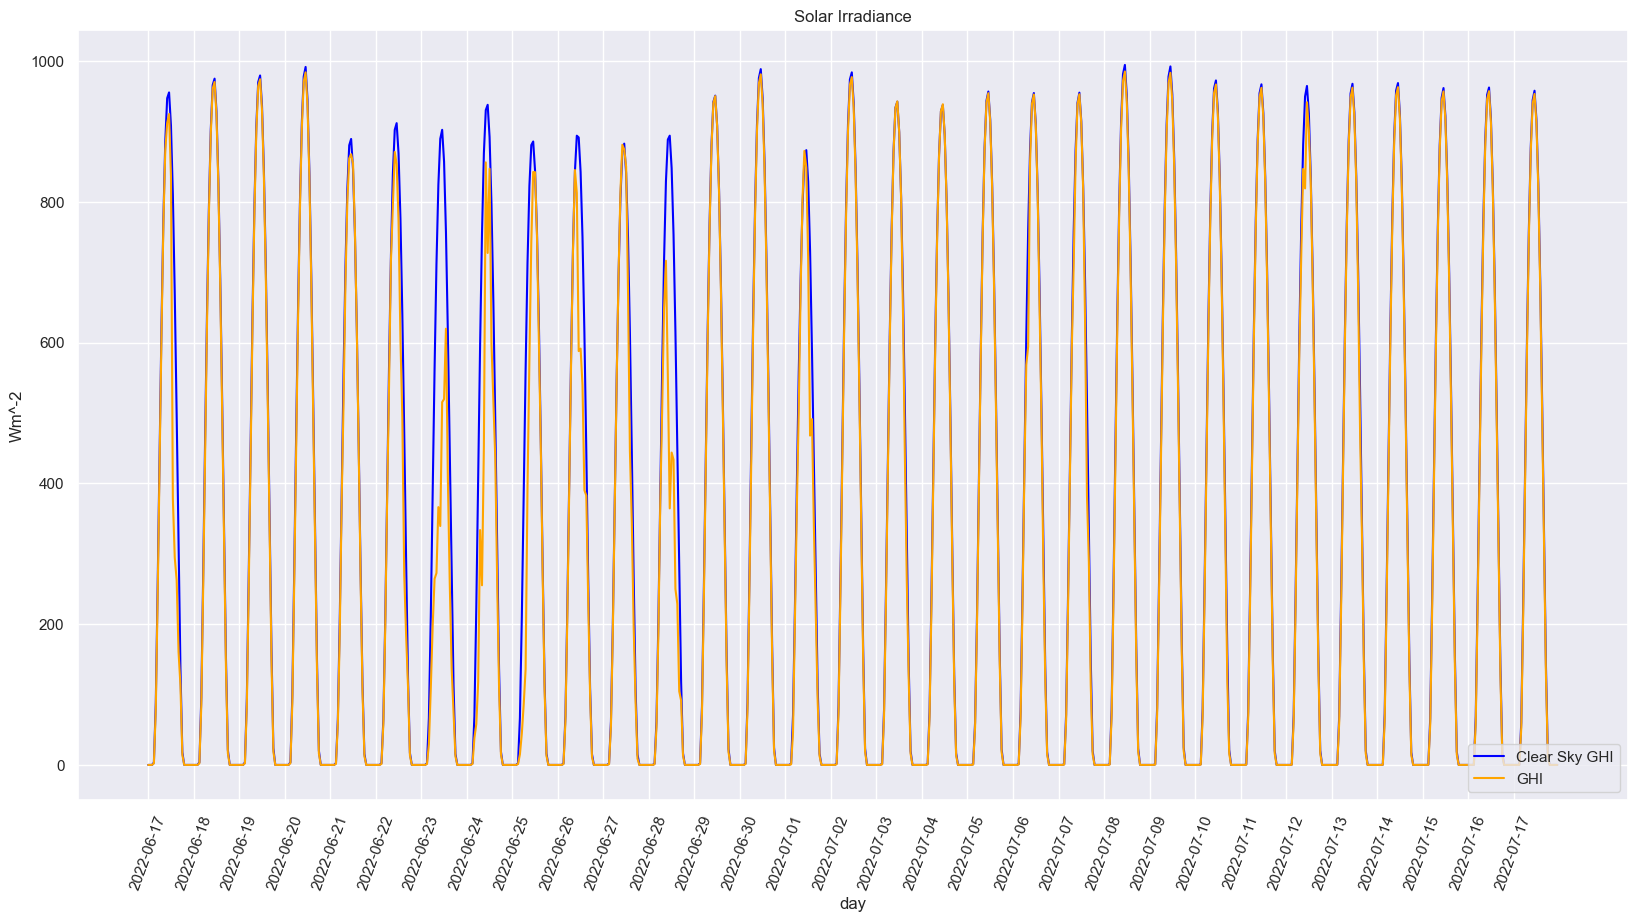

In [9]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Solar Irradiance")
ax.set_xlabel("day")
ax.set_ylabel("Wm^-2");
ax.set_xticks(days)
ax.set_xticklabels(days, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt_cs_ghi = plt.plot(cs_ghi_ts, color='blue')
plt_ghi = plt.plot(ghi_ts, color='orange')
plt.legend((plt_cs_ghi[0], plt_ghi[0]), ['Clear Sky GHI', 'GHI'], loc='lower right')

From the plot we can see that the day of the strongest irradiance attenuation is June 23th. Since we may want to automate the procedure, we implement the required steps. We first extract the daily maximum GHI (all-sky) irradiance and the daily maximum clear-sky irradiance. We then compute the ratios of the maximum values to find out the minimum ratio and the day in which it occurred.  

### Extracting the daily maximum GHI and Clear-sky GHI
We extract the all-sky GHI maximum values from the hourly observations for each day in the selected time interval and store them in a time-series.

In [10]:
daily_max_ghi = [ghi_ts[day.strftime('%Y-%m-%d')].max() for day in days]
daily_max_ghi_ts = pd.Series(daily_max_ghi, index=days)

We do the same with the Clear-sky GHI 

In [11]:
daily_max_cs_ghi = [cs_ghi_ts[day.strftime('%Y-%m-%d')].max() for day in days]
daily_max_cs_ghi_ts = pd.Series(daily_max_cs_ghi, index=days)

### Strongest irradiance attenuation
We compute the ratio of the maximum all-sky GHI and maximum Clear-sky GHI for each day in the selected time interval and then we extract the minimum value of the ratio and the day in which it occurred.

In [12]:
ratios = [daily_max_ghi_ts[day] / daily_max_cs_ghi_ts[day] for day in days] 
ratios_ts = pd.Series(ratios, index=days)
min_ratio = ratios_ts.min()
strongest_attenuation_day = ratios_ts.idxmin().strftime('%Y-%m-%d')
print("Day of strongest attenuation: {0:4s}\nAttenuation: {1:.4f}".format(strongest_attenuation_day, min_ratio))

Day of strongest attenuation: 2022-06-23
Attenuation: 0.6869


## Conclusion
We have successfully tested the CAMS solar radiation service API. It works well and it's easy to install and use. The CAMS solar radiation service is only one among many other data sets available as time series that provide reliable and high quality information about the atmosphere. This test has certainly awakened my appetite to use the other APIs and to learn more about the science behind the production of the data.      

## References
1. [ECMWF - User Guide to the CAMS Radiation Service (CRS)](https://atmosphere.copernicus.eu/sites/default/files/2021-05/CAMS72_2018SC1_D72.4.3.1_2021_UserGuide_v1.pdf)
2. [M. Lefevre et al. McClear: a new model estimating downwelling solar radiation at ground level in clear-sky conditions](https://amt.copernicus.org/articles/6/2403/2013/amt-6-2403-2013.pdf)
3. [Qu et al. Fast radiative transfer parameterisation for assessing the surface solar irradiance: The Heliosat‑4 method](https://dx.doi.org/10.1127/metz/2016/0781)